In [1]:
__updated__ = '2021-12-28 21:30:56'
import warnings
warnings.filterwarnings("ignore")

from Calculator import Calculator as Calc
# from PlotTools import createPlot
from utils import (
    pd, np, getSchema, getDateBeforeTrade, 
    saveRecommand, timedelta, GetException,
    sendResultTable, VolumeFilter, PriceFilter,
    changedType, datetime
)
import os
parent = os.path.dirname(os.path.abspath("__file__"))
output_path = os.path.join(parent, 'StrongResearch', 'CrossDayTrade_v3')
if not os.path.isdir(output_path):
    os.makedirs(output_path)
    


c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
def getLimit(price, pct=0.1, trend="U"):
    tmp_price = price
    if trend == "U":
        while 1:
            tick = Calc.get_minimum_tick(tmp_price)
            tmp_price += tick
            if (tmp_price/price) > 1 + pct:
                tmp_price -= tick
                break
    elif trend == "D":
        while 1:
            tick = Calc.get_minimum_tick(tmp_price)
            tmp_price -= tick
            if (tmp_price/price) < 1 - pct:
                tmp_price += tick
                break
            
    return round(tmp_price, 2)

In [21]:
def BacktestCrossDayTradeV3(td= datetime.today(), tp_ratio=.02, sl_ratio=.05):
    try:
        if td.isocalendar()[-1] > 5:
            tdStr = td.strftime("%Y-%m-%d")
            print(f"It\'s Holiday {tdStr}")
            return
        td, last = getDateBeforeTrade(td.replace(hour=18))
        pre_1y = td + timedelta(-365)
        tdStr = td.strftime("%Y-%m-%d")
        print(f"=============Start Backtest {tdStr}==================")
        # setup data
        schema = getSchema('TWSE')
        table = schema['StockList']
        last_date = sorted(table.distinct("UpdateDate"))[-1]
        info_data = dict((x['Ticker'], x['Industry']+f"({x['Market'][-1]})") for x in table.find({"UpdateDate":{"$eq":last_date}, "Industry" :{"$ne":""}}))

        schema = getSchema('TWSE')
        table = schema['historicalPrice']
        
        test_data = list(table.find({'Date':{'$gte':td.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$eq":"2330"}}))
        if not test_data:
            print(f"It\'s Holiday {tdStr}")
            return
        data = list(table.find({'Date':{'$gte':last.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$in":list(info_data.keys())}}))
        df = pd.DataFrame(data)
        if len(df.Date.unique()) <= 1:
            data = list(table.find({'Date':{'$gte':(td+timedelta(-30)).strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$in":list(info_data.keys())}}))
            df = pd.DataFrame(data)
            df = df[df.Date.isin(sorted(df.Date.unique())[-2:])]
            for col in 'Open,High,Low,Close,Volume'.split(','):
                df[col] = df[col].apply(changedType)
        
        print("Start Stock Picking")
        StrongTickers = []
        for ticker in list(info_data.keys()):
            try:
#                 print("Check", ticker)
                temp_data = list(table.find({'Date':{'$gte':pre_1y.strftime('%Y-%m-%d'), '$lte':last.strftime('%Y-%m-%d')}, "Ticker" :{"$eq":ticker}}))
                temp_df = pd.DataFrame(temp_data)
                for col in 'Open,High,Low,Close,Volume'.split(','):
                    temp_df[col] = temp_df[col].apply(changedType)
                temp_df = Calc.MA(temp_df, [5, 10, 20, 60])
                
                uplimit = getLimit(temp_df.Close.iloc[-4], .1)
#                 dnlimit = getLimit(temp_df.Close.iloc[-], sl_ratio, trend="D")
                
                last_2_bar = temp_df.Close.iloc[-2] < temp_df.Open.iloc[-2]
                last_1_bar = temp_df.Close.iloc[-1] < temp_df.Open.iloc[-1]
                long_trend = temp_df.MA5.iloc[-1] > temp_df.MA10.iloc[-1] and temp_df.MA10.iloc[-1] > temp_df.MA20.iloc[-1] and temp_df.MA20.iloc[-1] > temp_df.MA60.iloc[-1]
                test_ma5 = temp_df.Close.iloc[-1] > temp_df.MA5.iloc[-1] and temp_df.Close.iloc[-2] > temp_df.MA5.iloc[-2] and temp_df.Close.iloc[-3] > temp_df.MA5.iloc[-3]
                slope_60 = temp_df.MA60.iloc[-1] > temp_df.MA60.iloc[-2]
                if temp_df.Close.iloc[-3] >= uplimit and last_2_bar and last_1_bar and long_trend and test_ma5 and slope_60:
                    print("Check", ticker)
#                 if temp_df.High.iloc[-1] >= uplimit and temp_df.Volume.iloc[-2] / 1000 >= 1000: #  and temp_df['LowRet'].iloc[-1] > -.05
                    StrongTickers.append(ticker)
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except:
                print(GetException())
                pass
        print(td, StrongTickers)
        with open(os.path.join(output_path, f'{td.strftime("%Y%m%d")}_StrongTicker.csv'), 'w', encoding='utf-8') as f:
            for ticker in StrongTickers:
                f.writelines(ticker + '\n')
#         for ticker in StrongTickers:
#             tmp_df = df[df.Ticker == ticker]
#             entry_ = tmp_df.Close.iloc[-2]
            
        selected = StrongTickers
#         selected = []
#         for ticker in list(info_data.keys()):
#         #     print(ticker)
#             try:
#                 tmp_data = list(table.find({'Date':{'$gte':pre_1y.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$eq":ticker}}))

#                 tmp_df = pd.DataFrame(tmp_data)
#                 for col in 'Open,High,Low,Close,Volume'.split(','):
#                     tmp_df[col] = tmp_df[col].apply(changedType)

#                 tmp_df = Calc.MA(tmp_df, [5,10,20])
#                 tmp_df['Adj V'] = tmp_df.Volume.apply(lambda x: int(x/1000))
#                 if tmp_df['Adj V'].iloc[-1] < 1000:
#                     continue
#                 tmp_df['VMA5'] = tmp_df['Adj V'].rolling(5).mean()
#                 tmp_df['VMA10'] = tmp_df['Adj V'].rolling(10).mean()
#                 tmp_df['VMA20'] = tmp_df['Adj V'].rolling(20).mean()

#                 tmp_df['VSlope5'] = tmp_df['VMA5'].pct_change()
#                 tmp_df['VSlope10'] = tmp_df['VMA10'].pct_change()
#                 tmp_df['VSlope20'] = tmp_df['VMA20'].pct_change()

#                 tmp_df['Slope5'] = tmp_df['MA5'].pct_change()
#                 tmp_df['Slope10'] = tmp_df['MA10'].pct_change()
#                 tmp_df['Slope20'] = tmp_df['MA20'].pct_change()
#                 tmp_df['HC'] = tmp_df['High'] / tmp_df['Close'].shift(1) - 1
#                 tmp_df['HCMA'] = tmp_df['HC'].rolling(5).mean()# >= .05
#                 v_slope_condi = tmp_df.VSlope10.iloc[-1] > 0 and tmp_df.VSlope20.iloc[-1] > 0 and tmp_df.VSlope5.iloc[-1] > 0
#                 p_slope_condi = tmp_df.Slope10.iloc[-1] > 0 and tmp_df.Slope20.iloc[-1] > 0
#                 tr_condi = tmp_df['HCMA'].iloc[-1] >= .05
#                 v_condi = min(tmp_df['VMA5'].iloc[-1], tmp_df['VMA20'].iloc[-1]) >= 5000
#                 p_condi = tmp_df.Close.iloc[-1] < 500
#                 pct_condi = tmp_df['Close'].pct_change().iloc[-1] >= .06
# #                 k_condi_1 = not ((tmp_df['Close'].iloc[-1] < tmp_df['Open'].iloc[-1] or tmp_df['Close'].pct_change().iloc[-1] < 0) and tmp_df['Adj V'].pct_change().iloc[-1] < 0)
# #                 k_condi_2 = not (tmp_df['Close'].iloc[-1] < tmp_df['Open'].iloc[-1] and round(tmp_df['Adj V'].pct_change().iloc[-1],2) >= 1)
# #                 k_condi = all([k_condi_1, k_condi_2])
#                 tmp_tick = Calc.get_minimum_tick(tmp_df.Close.iloc[-1])
#                 limit_condi = True
#                 if (tmp_df.Close.iloc[-1] + tmp_tick) / tmp_df.Close.iloc[-2] > 1.1:
#                     limit_condi = False
#                 if (tmp_df.Close.iloc[-1] - tmp_tick) / tmp_df.Close.iloc[-2] < 0.9:
#                     limit_condi = False
#                 if v_slope_condi and p_slope_condi and tr_condi and v_condi and p_condi and limit_condi and pct_condi: #  and k_condi
#                     selected.append(ticker)
#             except:
#                 pass
#         print(selected, len(selected), '\n')
        if selected:
            ShowProfitable(selected, StrongTickers)
            CalculateBacktestResult(td, df, selected, StrongTickers, tp_ratio, sl_ratio)
        else:
            print("沒有符合條件的標的")
    except KeyboardInterrupt:
        raise KeyboardInterrupt
    except Exception as e:
        print(f"It\'s Holiday {tdStr}, {e}")
        print(GetException())
        pass

In [11]:
def ShowProfitable(selected, StrongTickers):
    profitable = list(set(selected).intersection(StrongTickers))
    unprofitable = list(set(selected).difference(StrongTickers))
    
    print('profitable',profitable, len(profitable))
    print('unprofitable',unprofitable, len(unprofitable))

def CalculateBacktestResult(td, df, selected, StrongTickers, tp_ratio=.02, sl_ratio=.05):
    try:
#         print(td, StrongTickers)
        with open(os.path.join(output_path, f'{td.strftime("%Y%m%d")}_ProfitLoss.csv'), 'w', encoding='utf-8') as f:
            f.writelines('Ticker,P/L,OpenRet,HighRet,LowRet,CloseRet,pnl\n')#,TakeProfit,StopLoss
            print('Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss\n')
            total_pnl = 0
            num_win = 0
            total_trade_value = 0
            for col in 'Open,High,Low,Close,Volume'.split(','):
                df[col] = df[col].apply(changedType)
            for ticker in StrongTickers:
                temp_df = df[df.Ticker==ticker]
#                 print(temp_df.Close.iloc[-2], type(temp_df.Close.iloc[-2]))
                uplimit = getLimit(temp_df.Close.iloc[-2], tp_ratio)
                upRet = (uplimit / temp_df.Close.iloc[-2] - 1) * 100
                dnlimit = getLimit(temp_df.Close.iloc[-2], sl_ratio, trend="D")
                dnRet = (dnlimit / temp_df.Close.iloc[-2] - 1) * 100

                temp_df['HighRet'] = (temp_df.High.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100
                temp_df['Ret'] = (temp_df.Close.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100
                temp_df['LowRet'] = (temp_df.Low.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100
                temp_df['OpenRet'] = (temp_df.Open.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100

                earning = 0
                exit = 0
                if temp_df['Open'].iloc[-1] >= uplimit:
                    exit = temp_df['Open'].iloc[-1]
                elif temp_df['Low'].iloc[-1] >= uplimit:
                    exit = temp_df['Low'].iloc[-1]
                elif temp_df['High'].iloc[-1] >= uplimit:
                    exit = uplimit
                if exit:
                    num_win += 1

                if not exit:
                    if temp_df['Open'].iloc[-1] <= dnlimit:
                        exit = temp_df['Open'].iloc[-1]
                    elif temp_df['High'].iloc[-1] <= dnlimit:
                        exit = temp_df['High'].iloc[-1]
                    elif temp_df['Low'].iloc[-1] <= dnlimit:
                        exit = dnlimit # temp_df.Close.iloc[-2] * (1 - .05)
                    else:
                        exit = temp_df['Close'].iloc[-1]
                print(f"{ticker}, take profit price :{uplimit}, stop loss price:{dnlimit}, entry : {temp_df.Close.iloc[-2]}. exit : {exit}")

                earning = int((exit - temp_df.Close.iloc[-2]) * 1000)
                earning -= round(temp_df.Close.iloc[-2] * 1.425)
                earning -= round(exit * 4.425)

                pnl = 'profit' if earning > 0 else 'loss'
                total_pnl += earning 
                total_trade_value += temp_df.Close.iloc[-2] * 1000
                text = f"{ticker},{pnl},{round(temp_df['OpenRet'].iloc[-1], 2)}%,{round(temp_df['HighRet'].iloc[-1], 2)}%,{round(temp_df['LowRet'].iloc[-1], 2)}%,{round(temp_df['Ret'].iloc[-1], 2)}%,{earning}\n"
    #             text = f"{ticker},{pnl},{round(temp_df['Open'].iloc[-1], 2)},{round(temp_df['High'].iloc[-1], 2)},{round(temp_df['Low'].iloc[-1], 2)},{round(temp_df['Close'].iloc[-1], 2)},{earning},{uplimit},{dnlimit}\n"
                f.writelines(text)
                text = f"股票={ticker},損/益={pnl},隔日開盤={temp_df['Open'].iloc[-1]},隔日最高={temp_df['High'].iloc[-1]},隔日收盤={temp_df['Close'].iloc[-1]},隔日最低={temp_df['Low'].iloc[-1]},損益金額={earning},漲停價={uplimit},跌停價={dnlimit}\n"
                print(text)
            total_ret = round((total_pnl / total_trade_value) * 100, 2)
            win_probability = round(num_win / len(selected)*100, 2)
            f.writelines(f"total,{win_probability}%,,,,{total_ret}%,{total_pnl},{total_trade_value}\n")
            print(f"total,勝率={win_probability}%,,,總報酬率={total_ret}%,,總損益={total_pnl},總交易金額={total_trade_value}\n")
    except Exception as e:
        print("CalculateBacktestResult, Error :",e)
        print(GetException())

In [22]:
# for date in pd.date_range(datetime(2021, 7, 1), datetime.today()):
# for date in pd.date_range(datetime(2018, 1, 2), datetime(2021,12,31)):# datetime(2020,12,31)
for date in pd.date_range(datetime(2020, 8, 1), datetime(2021,12,31)):# datetime(2020,12,31)
    try:
        BacktestCrossDayTradeV3(date, .02, .025)
    except KeyboardInterrupt:
        break

It's Holiday 2020-08-01
It's Holiday 2020-08-02
2020-08-03 18:00:00
=============Start Backtest 2020-08-03==================
Start Stock Picking
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
Check 3694
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
Check 6405
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 'Open'
 In (<ipython-input-21-1fcecfae481a>, Line 41 'temp_df[col] = temp_df[col].apply(changedType)') : 

In [20]:
# for date in pd.date_range(datetime(2021, 7, 1), datetime.today()):
#     try:
date = datetime(2020,7,28)
BacktestCrossDayTradeV3(date, .02, .025)
#     except KeyboardInterrupt:
#         break

2020-07-28 18:00:00
=============Start Backtest 2020-07-28==================
profitable ['3413', '5487', '6449', '6208', '2383', '1418'] 6
unprofitable [] 0
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

8.91 <class 'numpy.float64'>
1418, take profit price :9.08, stop loss price:8.69, entry : 8.91. exit : 8.8
股票=1418,損/益=loss,隔日開盤=8.91,隔日最高=8.91,隔日收盤=8.8,隔日最低=8.8,損益金額=-161,漲停價=9.08,跌停價=8.69

169.5 <class 'numpy.float64'>
2383, take profit price :172.5, stop loss price:165.5, entry : 169.5. exit : 172.5
股票=2383,損/益=profit,隔日開盤=171.0,隔日最高=175.0,隔日收盤=167.0,隔日最低=165.5,損益金額=1995,漲停價=172.5,跌停價=165.5

209.0 <class 'numpy.float64'>
3413, take profit price :213.0, stop loss price:204.0, entry : 209.0. exit : 213.0
股票=3413,損/益=profit,隔日開盤=211.5,隔日最高=217.0,隔日收盤=202.5,隔日最低=201.0,損益金額=2759,漲停價=213.0,跌停價=204.0

38.8 <class 'numpy.float64'>
6449, take profit price :39.55, stop loss price:37.85, entry : 38.8. exit : 39.55
股票=6449,損/益=profit,隔日開盤=39.35,隔日最高=39.65,隔日收盤=36.7,隔日最低=35.65,損益金額=520,

In [6]:
pnl_cum = []
for back_date in pd.date_range(datetime(2018,1,1), datetime.today()):#
# for back_date in pd.date_range(datetime(2021,8,1), datetime(2022,8,31)):#.today()
    dtStr = back_date.strftime("%Y%m%d")
    f_path = os.path.join(output_path, f"{dtStr}_ProfitLoss.csv")
    if os.path.isfile(f_path):
        try:
            with open(f_path, 'r') as f:
                lines = f.readlines()
#                 print(dtStr, lines[-1])
                pnl_cum.append({
                    "Date":back_date.strftime("%Y-%m-%d"),
                    "PnL":int(lines[-1].split(',')[-2]),
                    "TradeValue":int(float(lines[-1].split(',')[-1]))
                })
        except:
            print(lines[-1])
            

In [14]:
pnl_df = pd.DataFrame(pnl_cum).set_index('Date')#.PnL.cumsum().plot(figsize=(16,8))

In [18]:
pnl_df[pnl_df.PnL>0].shape[0], pnl_df[pnl_df.PnL<=0].shape[0], pnl_df[pnl_df.PnL>0].shape[0] / pnl_df.shape[0]

(76, 53, 0.5891472868217055)

In [13]:
pd.DataFrame(pnl_cum).set_index('Date')#.cumsum().plot(figsize=(16,8))

,PnL,TradeValue
Date,,
2018-01-03,1119,55550
2018-01-08,415,31200
2018-01-11,309,23600
2018-01-12,-3747,130000
2018-01-17,1669,123200
...,...,...
2019-10-17,172,13000
2019-10-18,-3133,110000
2019-10-25,761,57100


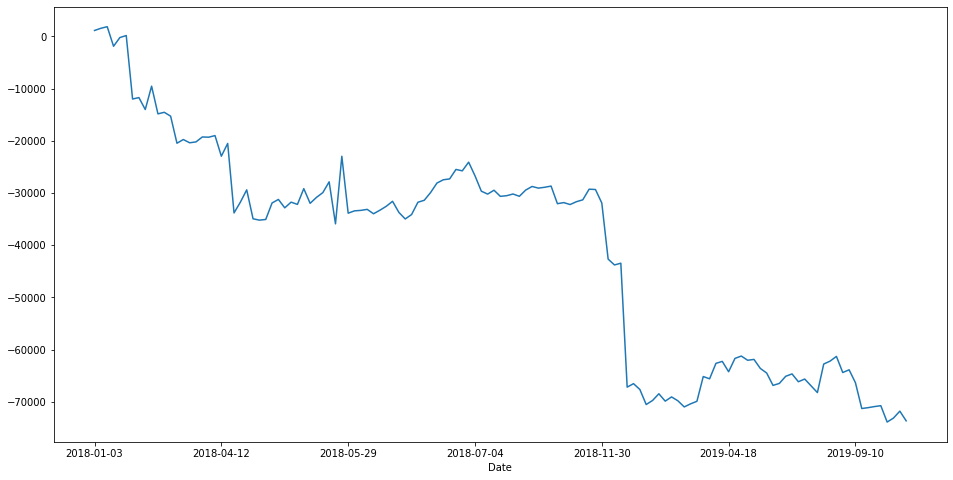

In [7]:
pd.DataFrame(pnl_cum).set_index('Date').PnL.cumsum().plot(figsize=(16,8))

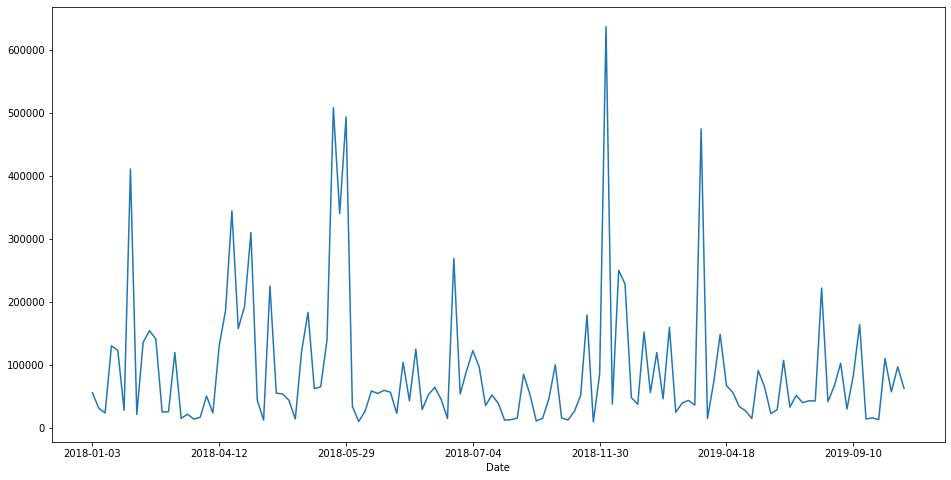

In [8]:
pd.DataFrame(pnl_cum).set_index('Date').TradeValue.plot(figsize=(16,8))

Date
2007-01-03       1
2007-01-04       2
2007-01-05       3
2007-01-08       6
2007-01-09       7
              ... 
2017-04-25    3766
2017-04-26    3767
2017-04-27    3768
2017-04-28    3769
2017-05-01    3772
Name: date_id, Length: 2600, dtype: int64


<AxesSubplot:xlabel='Date'>

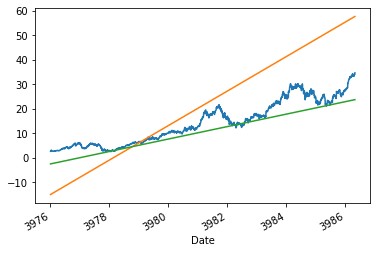

In [30]:
# import pandas as pd
# import quandl as qdl
from pandas_datareader import data as web
from scipy.stats import linregress

# get AAPL 10 years data

# data = qdl.get("WIKI/AAPL", start_date="2007-01-01", end_date="2017-05-01")
data = web.DataReader("AAPL",'yahoo',"2007-01-01", "2017-05-01")
# print(data)
data0 = data.copy()

data0['date_id'] = ((data0.index.date - data0.index.date.min())).astype('timedelta64[D]')
data0['date_id'] = data0['date_id'].dt.days + 1

# high trend line
print(data0['date_id'])
data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['High'],
                    )
    data1 = data1.loc[data1['High'] > reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['High'],
                    )

data0['high_trend'] = reg[0] * data0['date_id'] + reg[1]

# low trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['Low'],
                    )
    data1 = data1.loc[data1['Low'] < reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['Low'],
                    )

data0['low_trend'] = reg[0] * data0['date_id'] + reg[1]

# plot

data0['Adj Close'].plot()
data0['high_trend'].plot()
data0['low_trend'].plot()